<a href="https://colab.research.google.com/github/m-zaniolo/CEE690-ESAA/blob/main/Lab_07_synthetic_streamflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 7 - thomas Fiering synthetic generation
_____________


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (10, 4)

## Stationary Generation

In [2]:
url = 'https://raw.githubusercontent.com/m-zaniolo/CEE690-ESAA/main/data/'

df = pd.read_csv(url+'inflow.txt', header=None) # a pandas series (daily)
df.columns = ['inflow']

# generate date array
# Generate the full date range from January 1, 2001, to December 31, 2015
date_range = pd.date_range(start='2001-01-01', end='2015-12-31', freq='D')

# Filter out all February 29 instances
date_range = date_range[~((date_range.month == 2) & (date_range.day == 29))]

df.index = date_range
df_annual = df.resample('YE').sum() # annual values

Q = df_annual.inflow
print(Q.autocorr(lag=1)) # lag (k)

# lag of 1 is small, and within CI of zero (see below)

0.3024823710394227


In [3]:
#more generically, if you are not using a pandas data series, you can write your own autocorrelation function. We'll use it later
def autocorr(x,k):
    return np.corrcoef(x[:len(x)-k], x[k:])[0,1]

Plot a __correlogram__ with confidence bounds

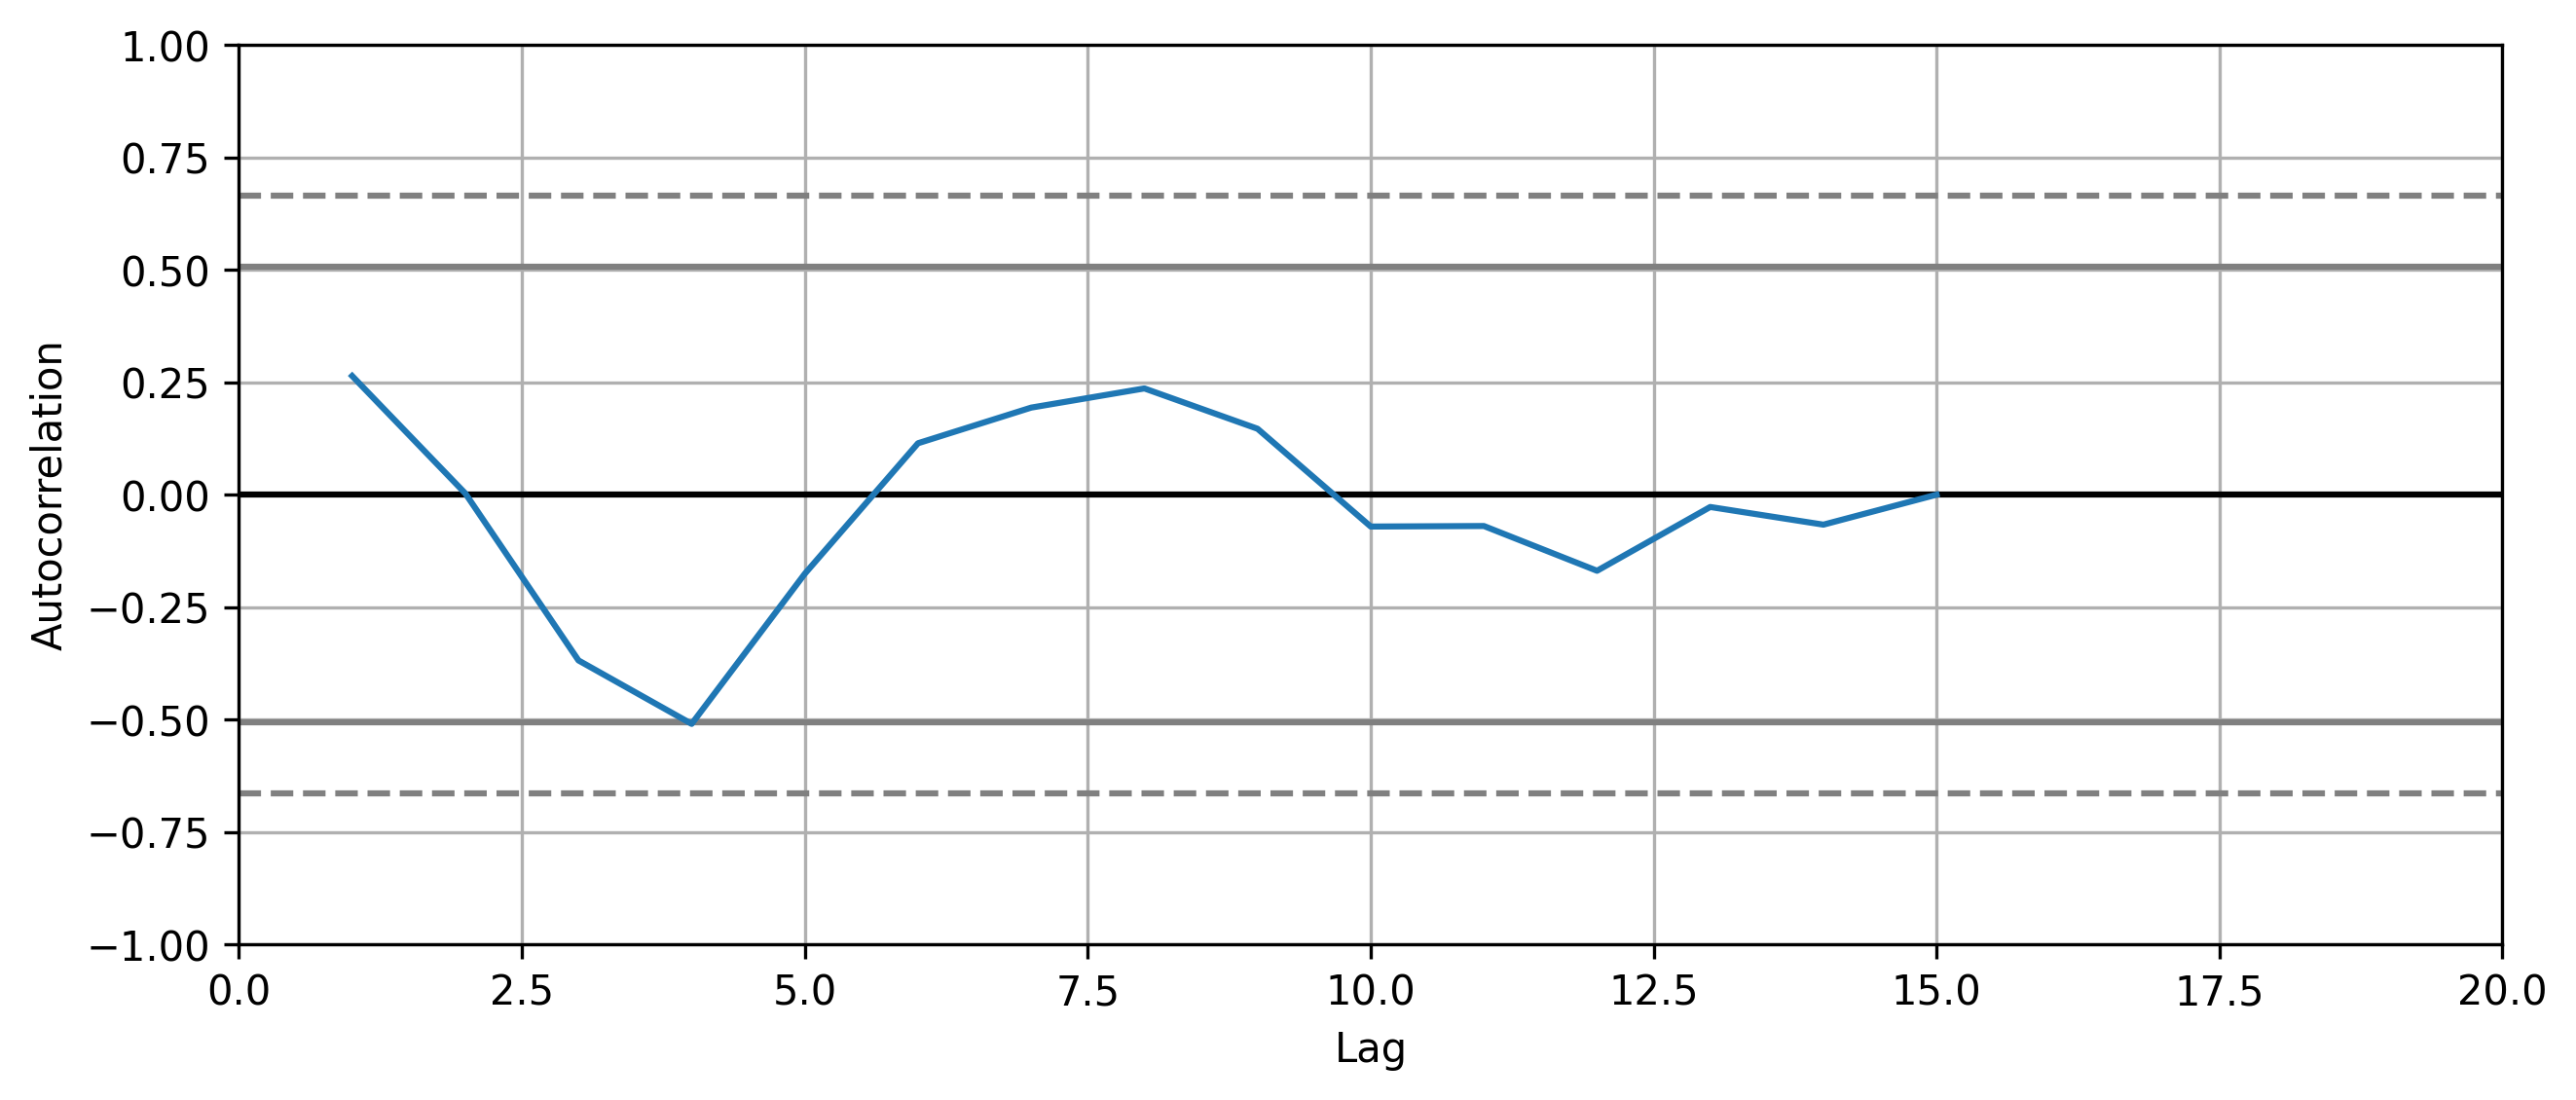

In [4]:
pd.plotting.autocorrelation_plot(Q)
plt.xlim([0,20])
plt.show()

Partial autocorrelation function (PACF)

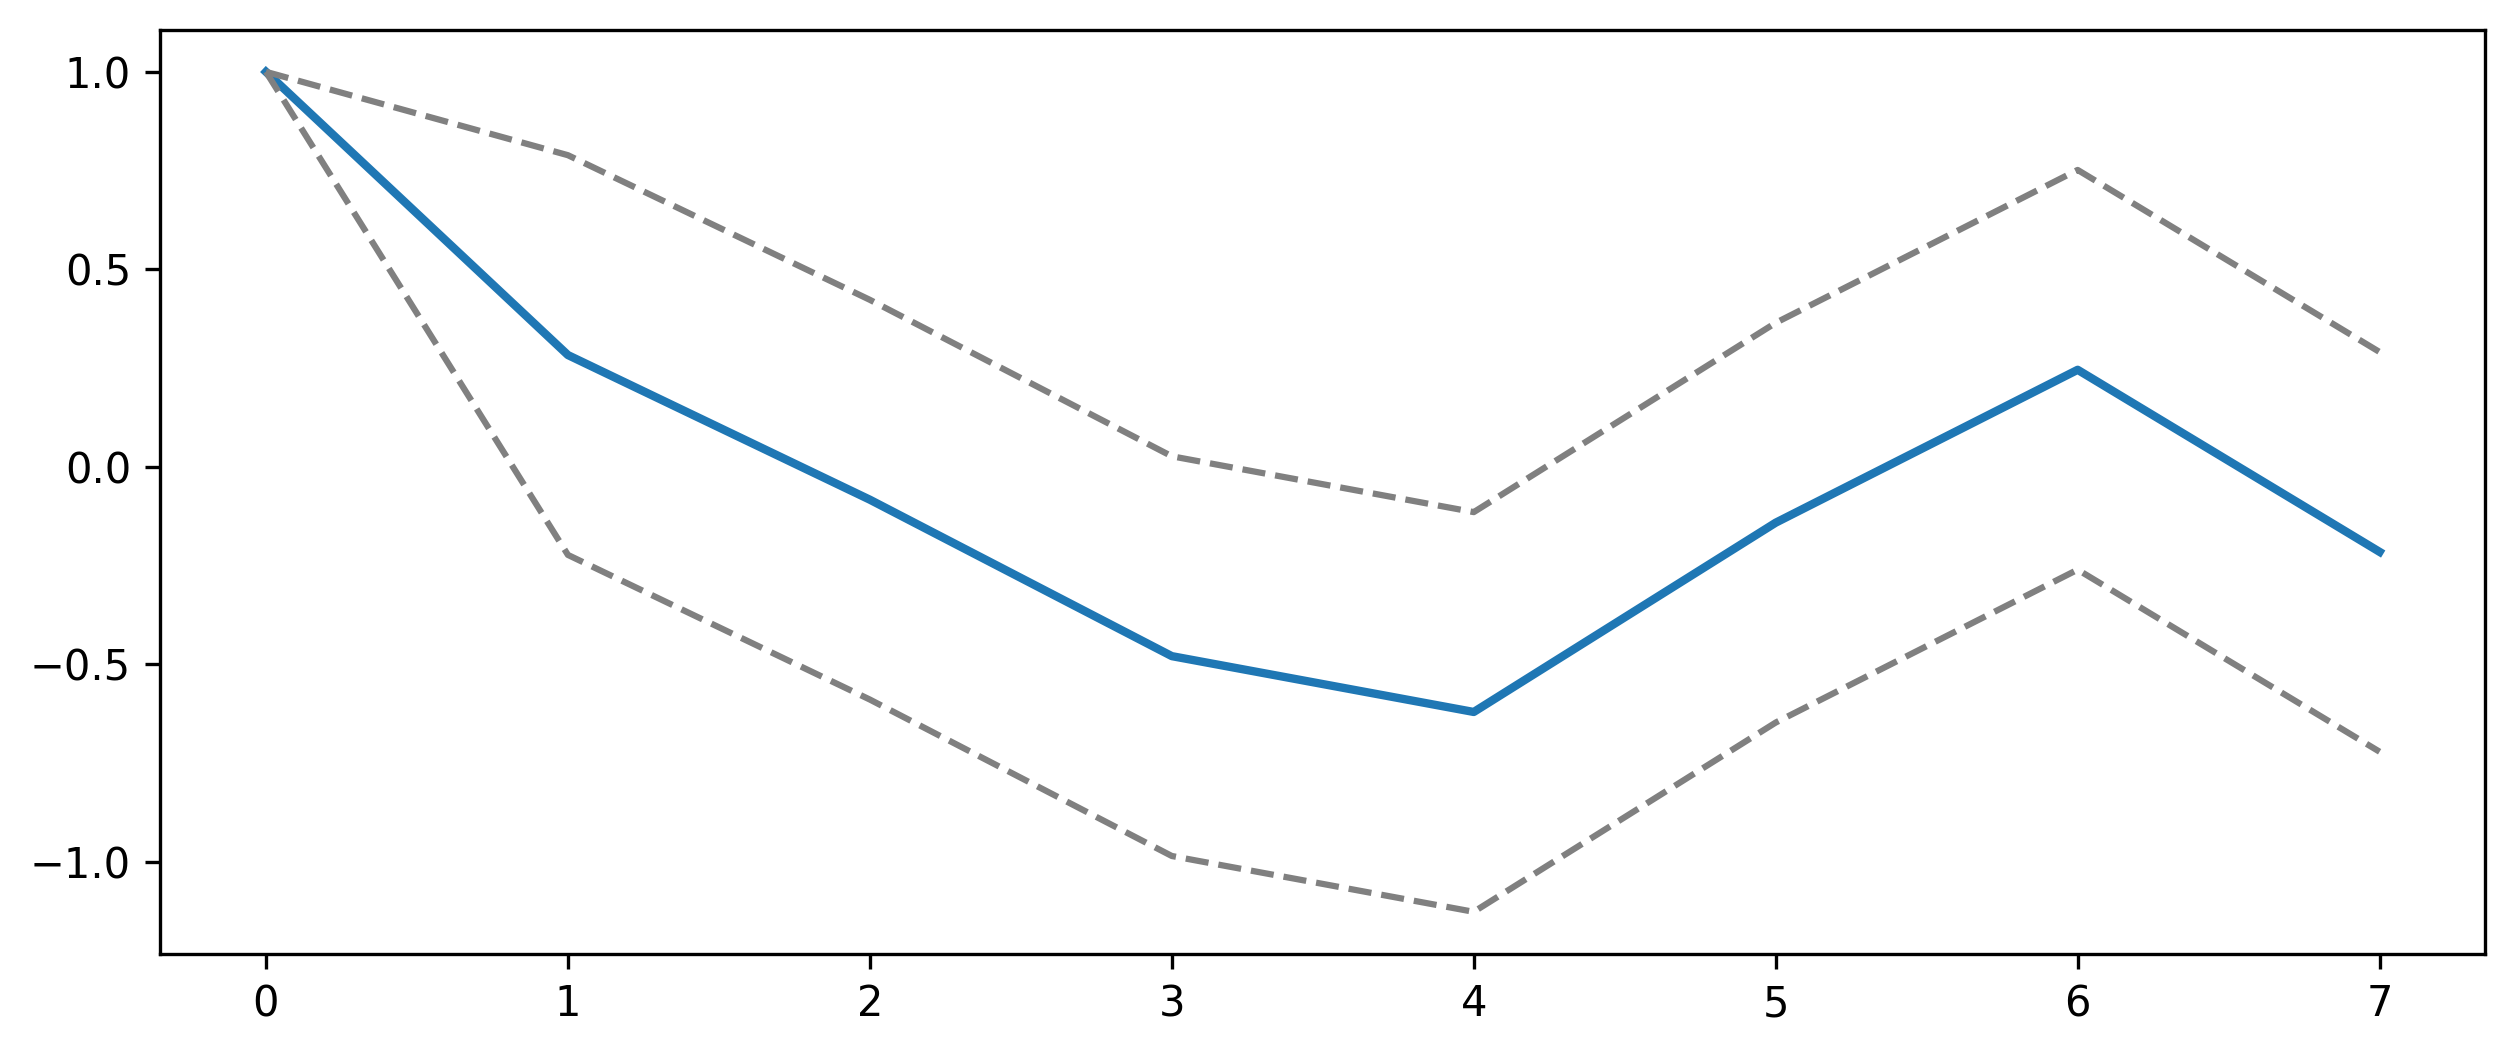

In [5]:
from statsmodels.tsa import stattools
pacf,ci = stattools.pacf(Q, nlags=7, alpha=0.05)
plt.plot(pacf, linewidth=2) # pacf is the partial autocorrelation function
plt.plot(ci, linestyle='dashed', color='0.5')
plt.show()

------------

### _Thomas-Fiering method_ (annual)

Thomas-Fiering (AR-1) method for annual flows

In [7]:
np.random.seed(1) #for reproducibility

In [8]:
def thomasfiering(x,N):
    '''Lag-1 model. use historical data x
    to generate a synthetic sequence of N timesteps.
    Assumes x is lognormally distributed.'''
    x = np.log(x) # log-space avoids negative values and respects normal distribution assumption
    mu = x.mean()
    sigma = x.std()
    rho = autocorr(x,1)
    Q = np.zeros(N) # initialize
    Q[0] = np.random.normal(mu,sigma,1)

    for i in range(1,N):
        Z = np.random.standard_normal() # Z is called V in the L8 slides
        Q[i] = mu + rho*(Q[i-1] - mu) + Z*sigma*np.sqrt(1-rho**2)

    return np.exp(Q) # it was in log-transformed space, so exponentiate it to return it to real space

Assume annual flow data is lognormally distributed

In [9]:
Q_synthetic = thomasfiering(Q, N=100) # N=100 generates 200 years

<ipython-input-8-02c8ebd2e098>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[0] = np.random.normal(mu,sigma,1)


In [10]:
print('Means: %f, %f' % (Q.mean(), Q_synthetic.mean()))
print('Stdev: %f, %f' % (Q.std(), Q_synthetic.std()))
print('Rho: %f, %f' % (autocorr(Q,1), autocorr(Q_synthetic,1)))

Means: 102440.760333, 104052.373874
Stdev: 22514.865016, 21568.581391
Rho: 0.302482, 0.273120


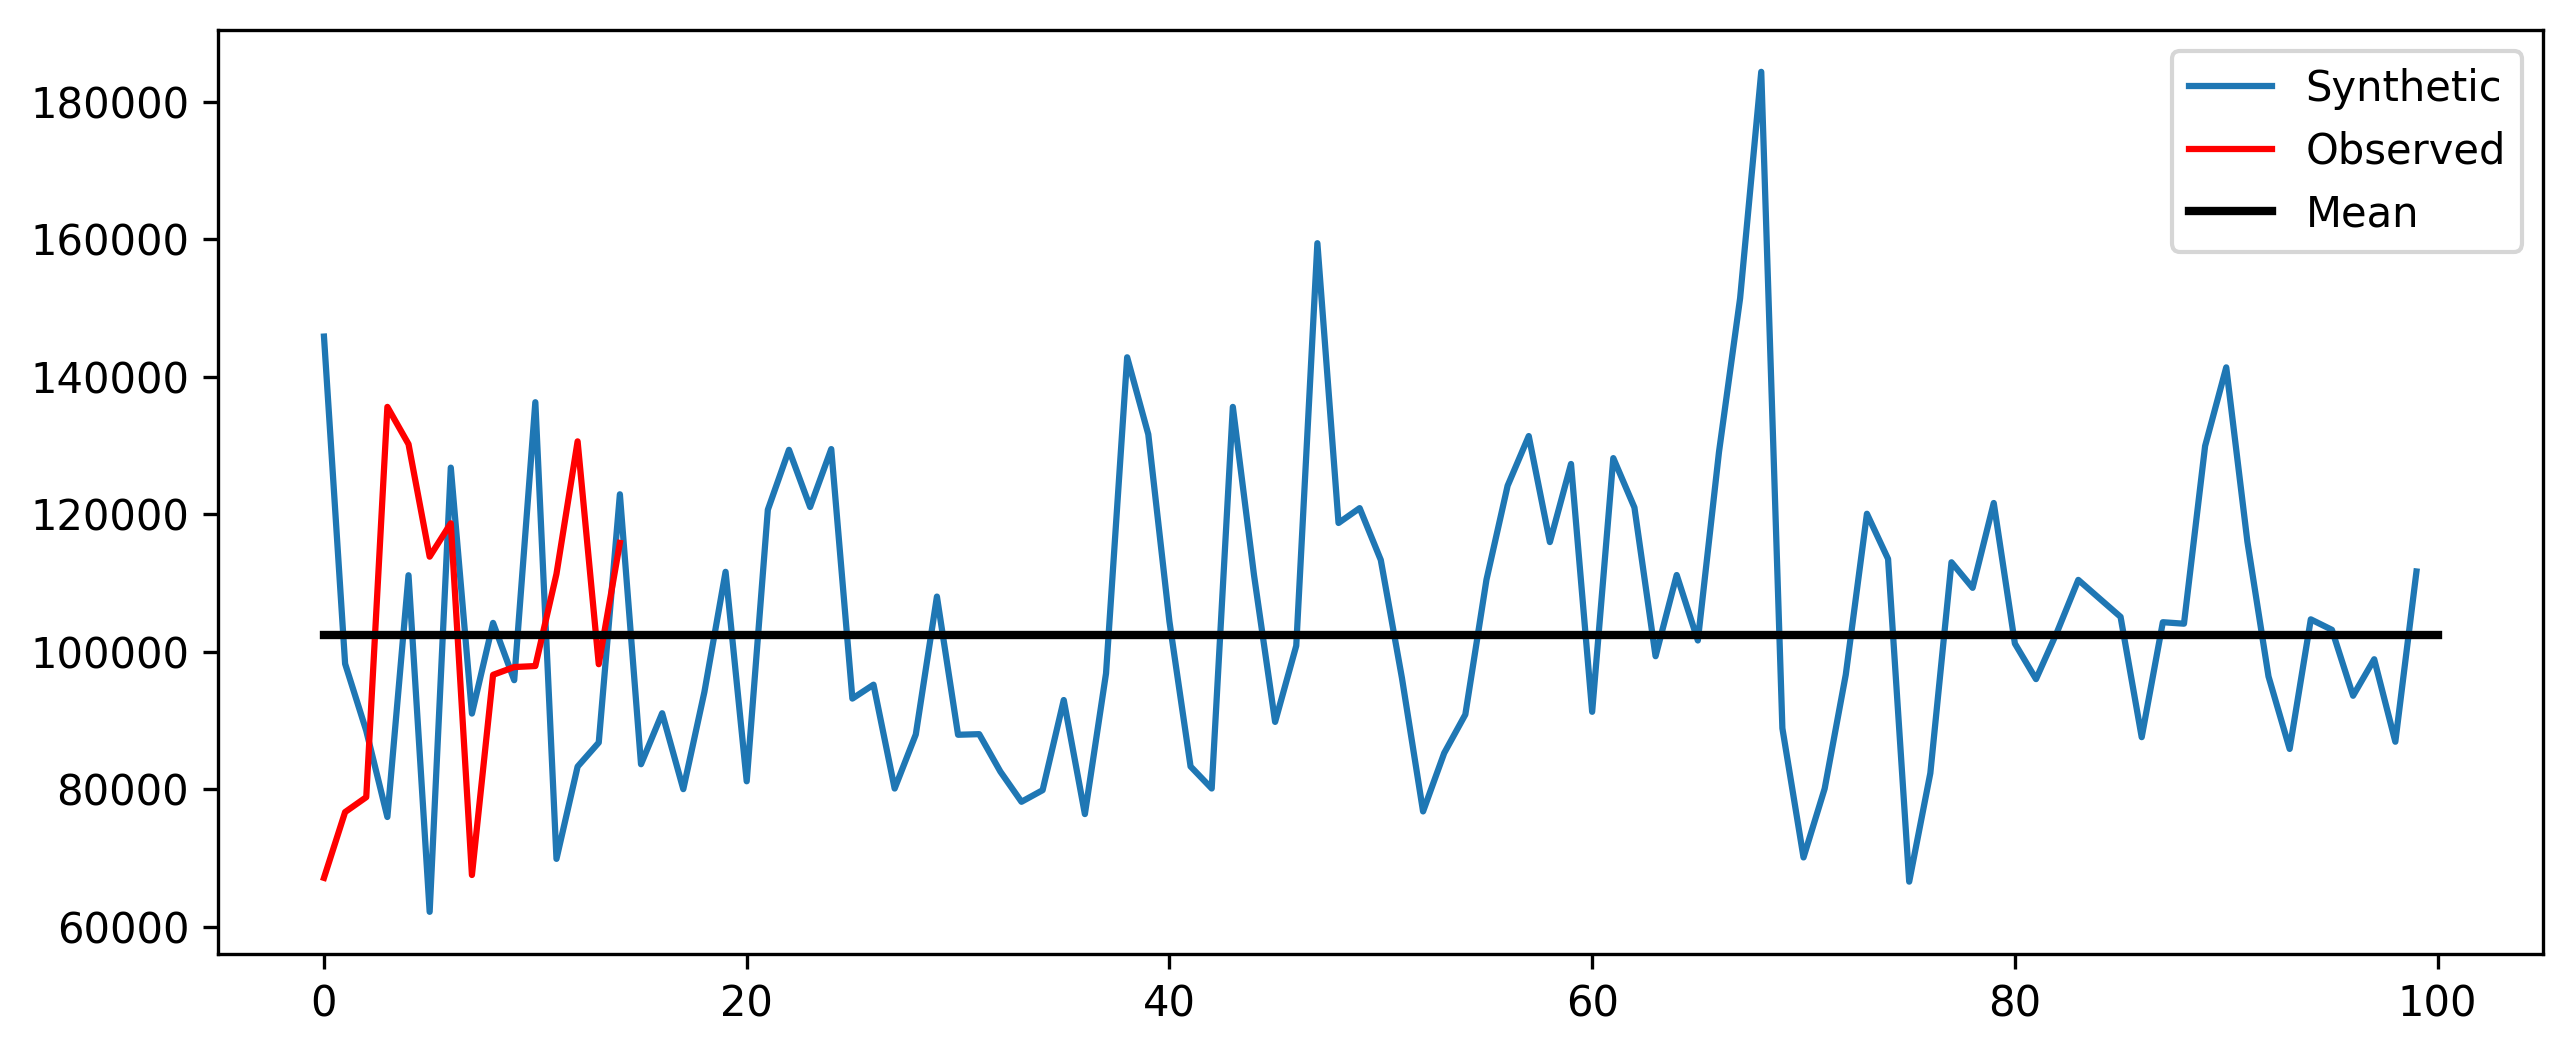

In [11]:
plt.plot(Q_synthetic)
plt.plot(Q.values, color='red')
plt.plot([0,100], [Q.mean(), Q.mean()], color='k', linewidth=2)
plt.legend(['Synthetic', 'Observed', 'Mean'])
plt.show()

# note the extremes in the synthetic timeseries may not be physically plausible

-----------

### _Thomas-Fiering method (monthly)_

Rather than resampling annually, we resample monthly

0.7155210296240122


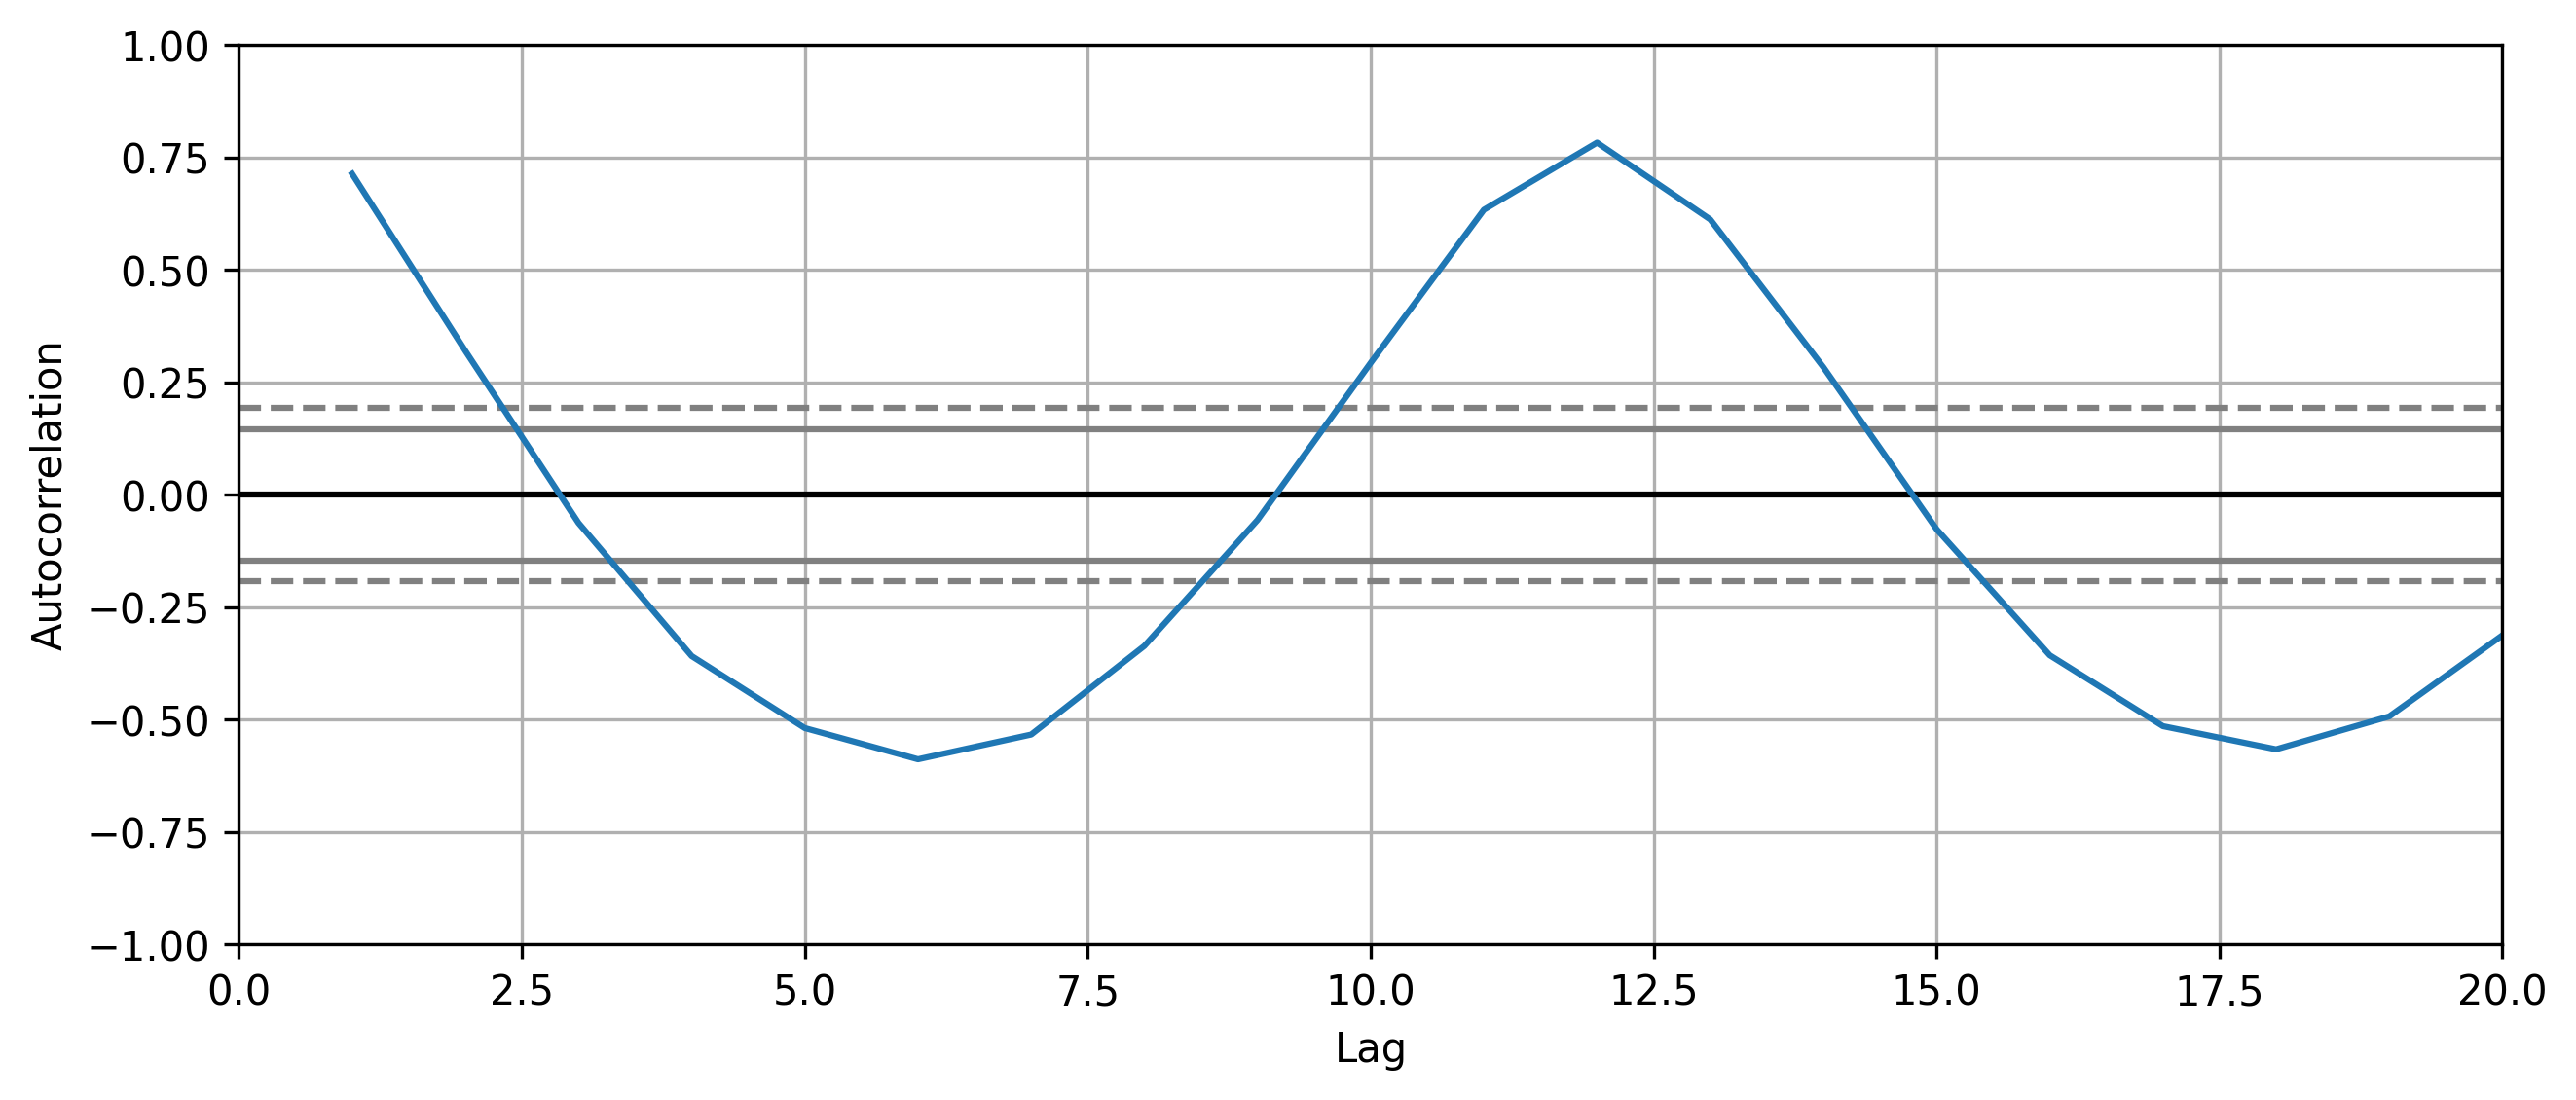

In [12]:
df_monthly = df.resample('ME').mean() # annual values
Q = df_monthly.inflow
print(Q.autocorr(lag=1)) # higher monthly autocorrelation

pd.plotting.autocorrelation_plot(Q)
plt.xlim([0,20])
plt.show()

In [14]:
# rewrite T-F for monthly data. It's similar to annual, but it loops through the 12 months
def thomasfiering_monthly(mu, sigma, rho, N_years):
    '''Lag-1 model. use historical monthly statistics to generate
    a synthetic sequence of N years'''

    Q = np.zeros(N_years*12) # initialize
    Q[0] = np.random.normal(mu[0],sigma[0],1)

    for y in range(N_years):
        for m in range(12): ##### for monthly data!
            i = 12*y + m # index

            if i > 0:
                Z = np.random.standard_normal()
                Q[i] = mu[m] + rho[m-1]*(Q[i-1] - mu[m-1]) + Z*sigma[m]*np.sqrt(1-rho[m-1]**2)

    return np.exp(Q) # real space

In [15]:
# Bafore using the above function, we have to calculate monthly statistics of mu, sigma, rho necessary as input

def get_monthly_stats(x):
    '''calculate monthly mean, std. dev., and lag-1 autocorrelation
    from historical data x. Assumes each month is lognormally distributed.'''

    x = np.log(x)
    N = len(x)
    mu = np.zeros(12)
    sigma = np.zeros(12)
    rho = np.zeros(12) # varies the autocorrelation

    for m in range(12): # loops over all 12 months
        mu[m] = x[m::12].mean() # m::12 is array slicing, picking out every 12; start in month m, go to the end in steps of 12
        sigma[m] = x[m::12].std()
        x1 = x[m:N-1:12]
        x2 = x[m+1::12]
        rho[m] = np.corrcoef(x1,x2)[0,1] # index the matrix

    return mu,sigma,rho # log space

Generate synthetic timeseries

In [16]:
mu,sigma,rho = get_monthly_stats(Q)
Q_synthetic = thomasfiering_monthly(mu, sigma, rho, N_years=15)

<ipython-input-14-69e47f17e5d5>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[0] = np.random.normal(mu[0],sigma[0],1)


Compare synthetic stats to historical

In [17]:
a,b,c = get_monthly_stats(Q_synthetic)

for m in range(12):
    print('Month %d means: %f, %f' % (m,mu[m],a[m]))
for m in range(12):
    print('Month %d stdev: %f, %f' % (m,sigma[m],b[m]))
for m in range(12):
    print('Month %d rho: %f, %f' % (m,rho[m],c[m]))

Month 0 means: 4.054281, 4.108673
Month 1 means: 3.967972, 4.047887
Month 2 means: 4.114034, 4.355875
Month 3 means: 4.501746, 4.564866
Month 4 means: 5.368815, 5.469183
Month 5 means: 5.846612, 5.935403
Month 6 means: 6.329045, 6.411030
Month 7 means: 6.580041, 6.659151
Month 8 means: 6.401057, 6.351787
Month 9 means: 5.532218, 5.538635
Month 10 means: 4.656991, 4.707587
Month 11 means: 4.220760, 4.260719
Month 0 stdev: 0.180042, 0.287119
Month 1 stdev: 0.199113, 0.231009
Month 2 stdev: 0.460968, 0.277324
Month 3 stdev: 0.382722, 0.428672
Month 4 stdev: 0.729871, 0.534295
Month 5 stdev: 0.477685, 0.503908
Month 6 stdev: 0.348129, 0.385239
Month 7 stdev: 0.280966, 0.257339
Month 8 stdev: 0.256648, 0.332101
Month 9 stdev: 0.379502, 0.334613
Month 10 stdev: 0.443259, 0.377964
Month 11 stdev: 0.145943, 0.308221
Month 0 rho: 0.761764, 0.842895
Month 1 rho: 0.171281, 0.603622
Month 2 rho: 0.597650, 0.840079
Month 3 rho: 0.556786, 0.013983
Month 4 rho: 0.627260, 0.524163
Month 5 rho: 0.65127

Plot timeseries

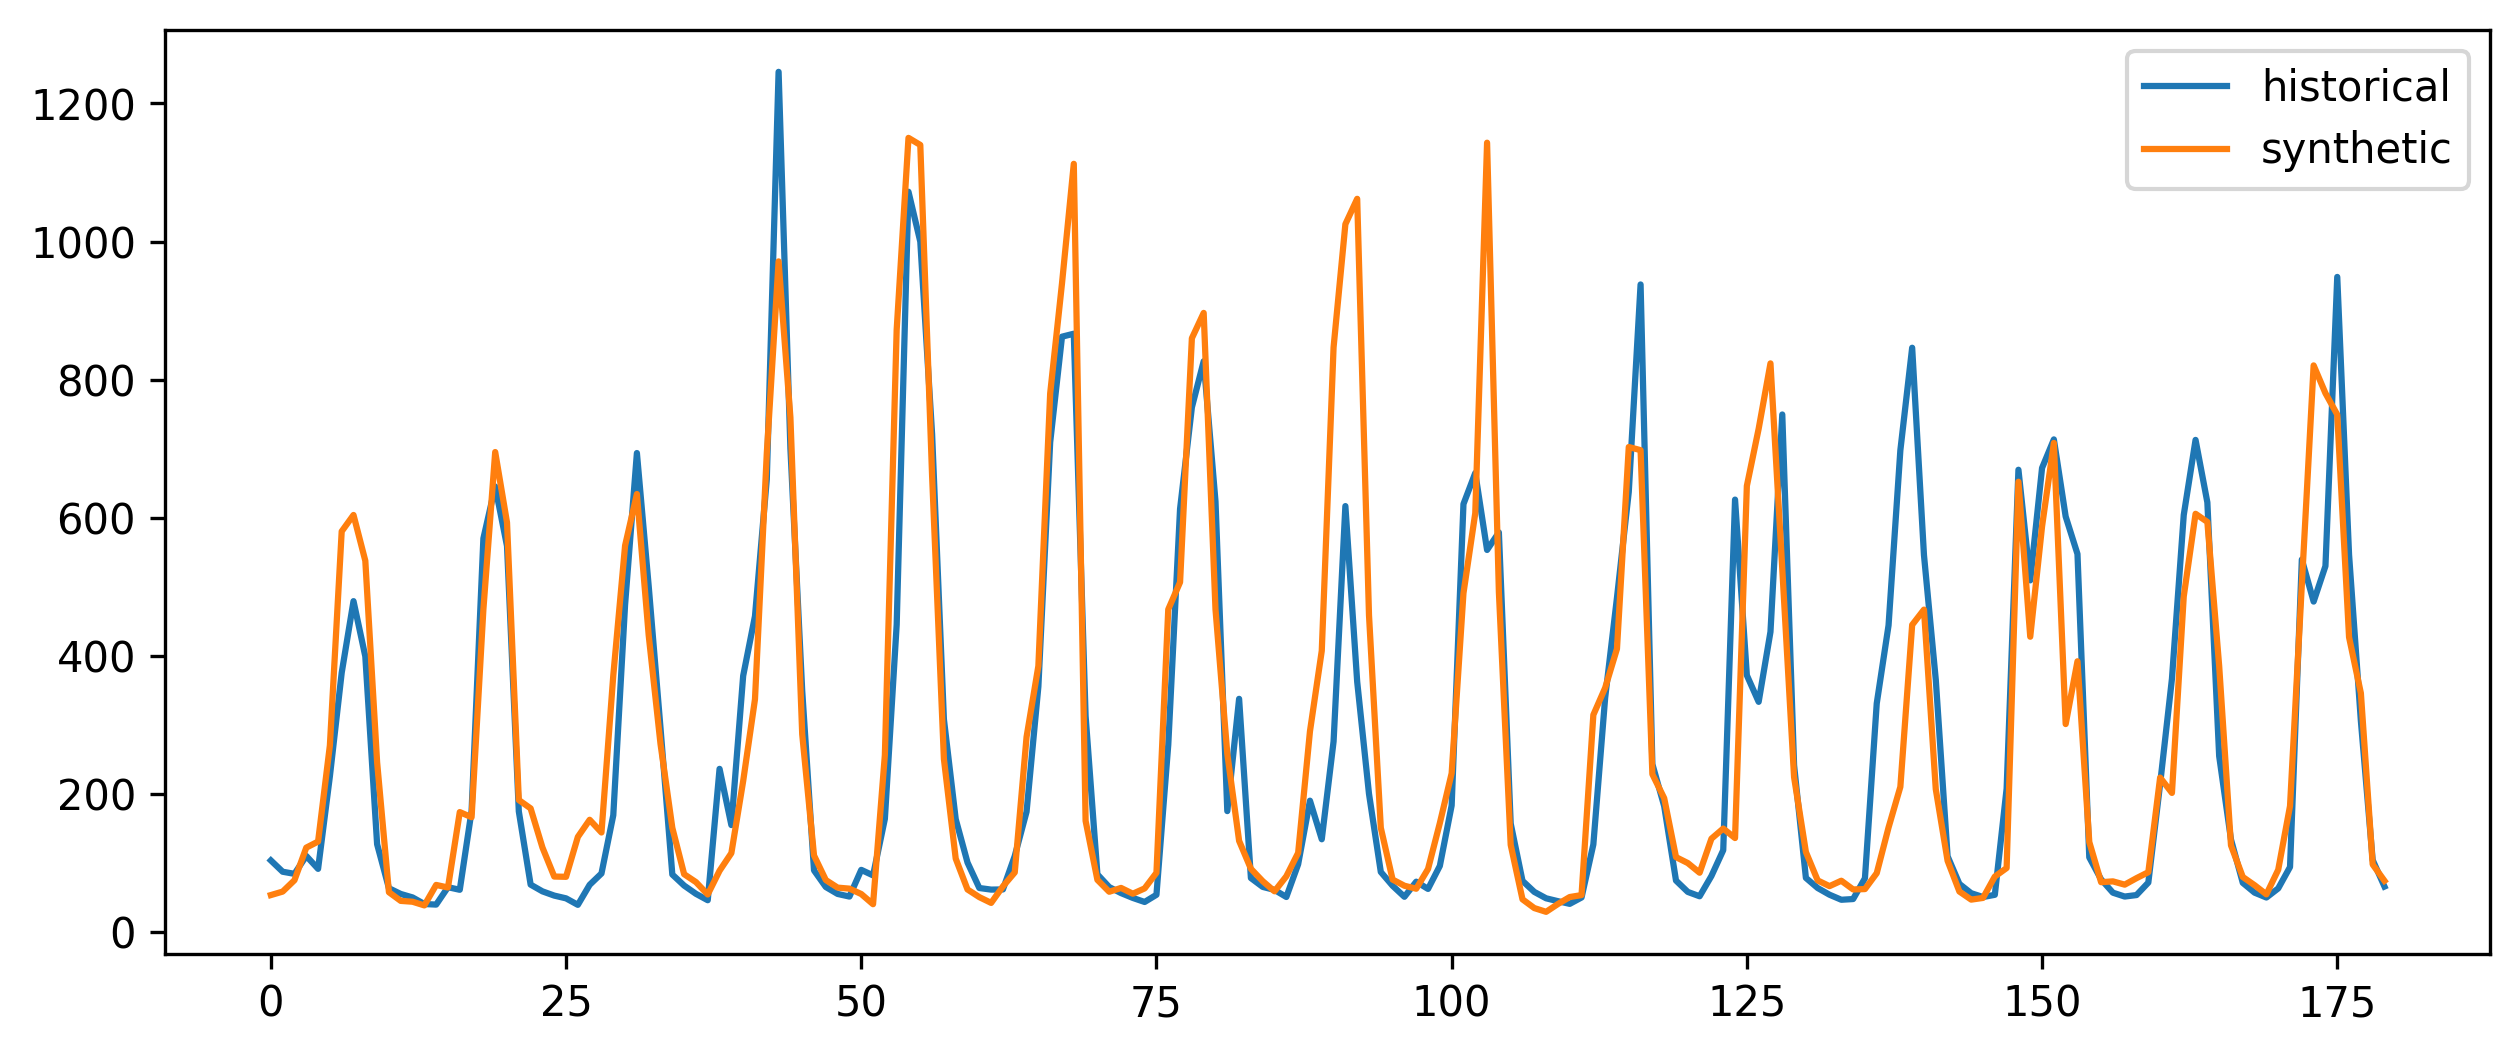

In [18]:
plt.plot(Q.values, label = 'historical')
plt.plot(Q_synthetic, label = 'synthetic')
plt.legend()
plt.show()

Compare ACF/PACF in historical and synthetic

In [19]:
from statsmodels.tsa import stattools

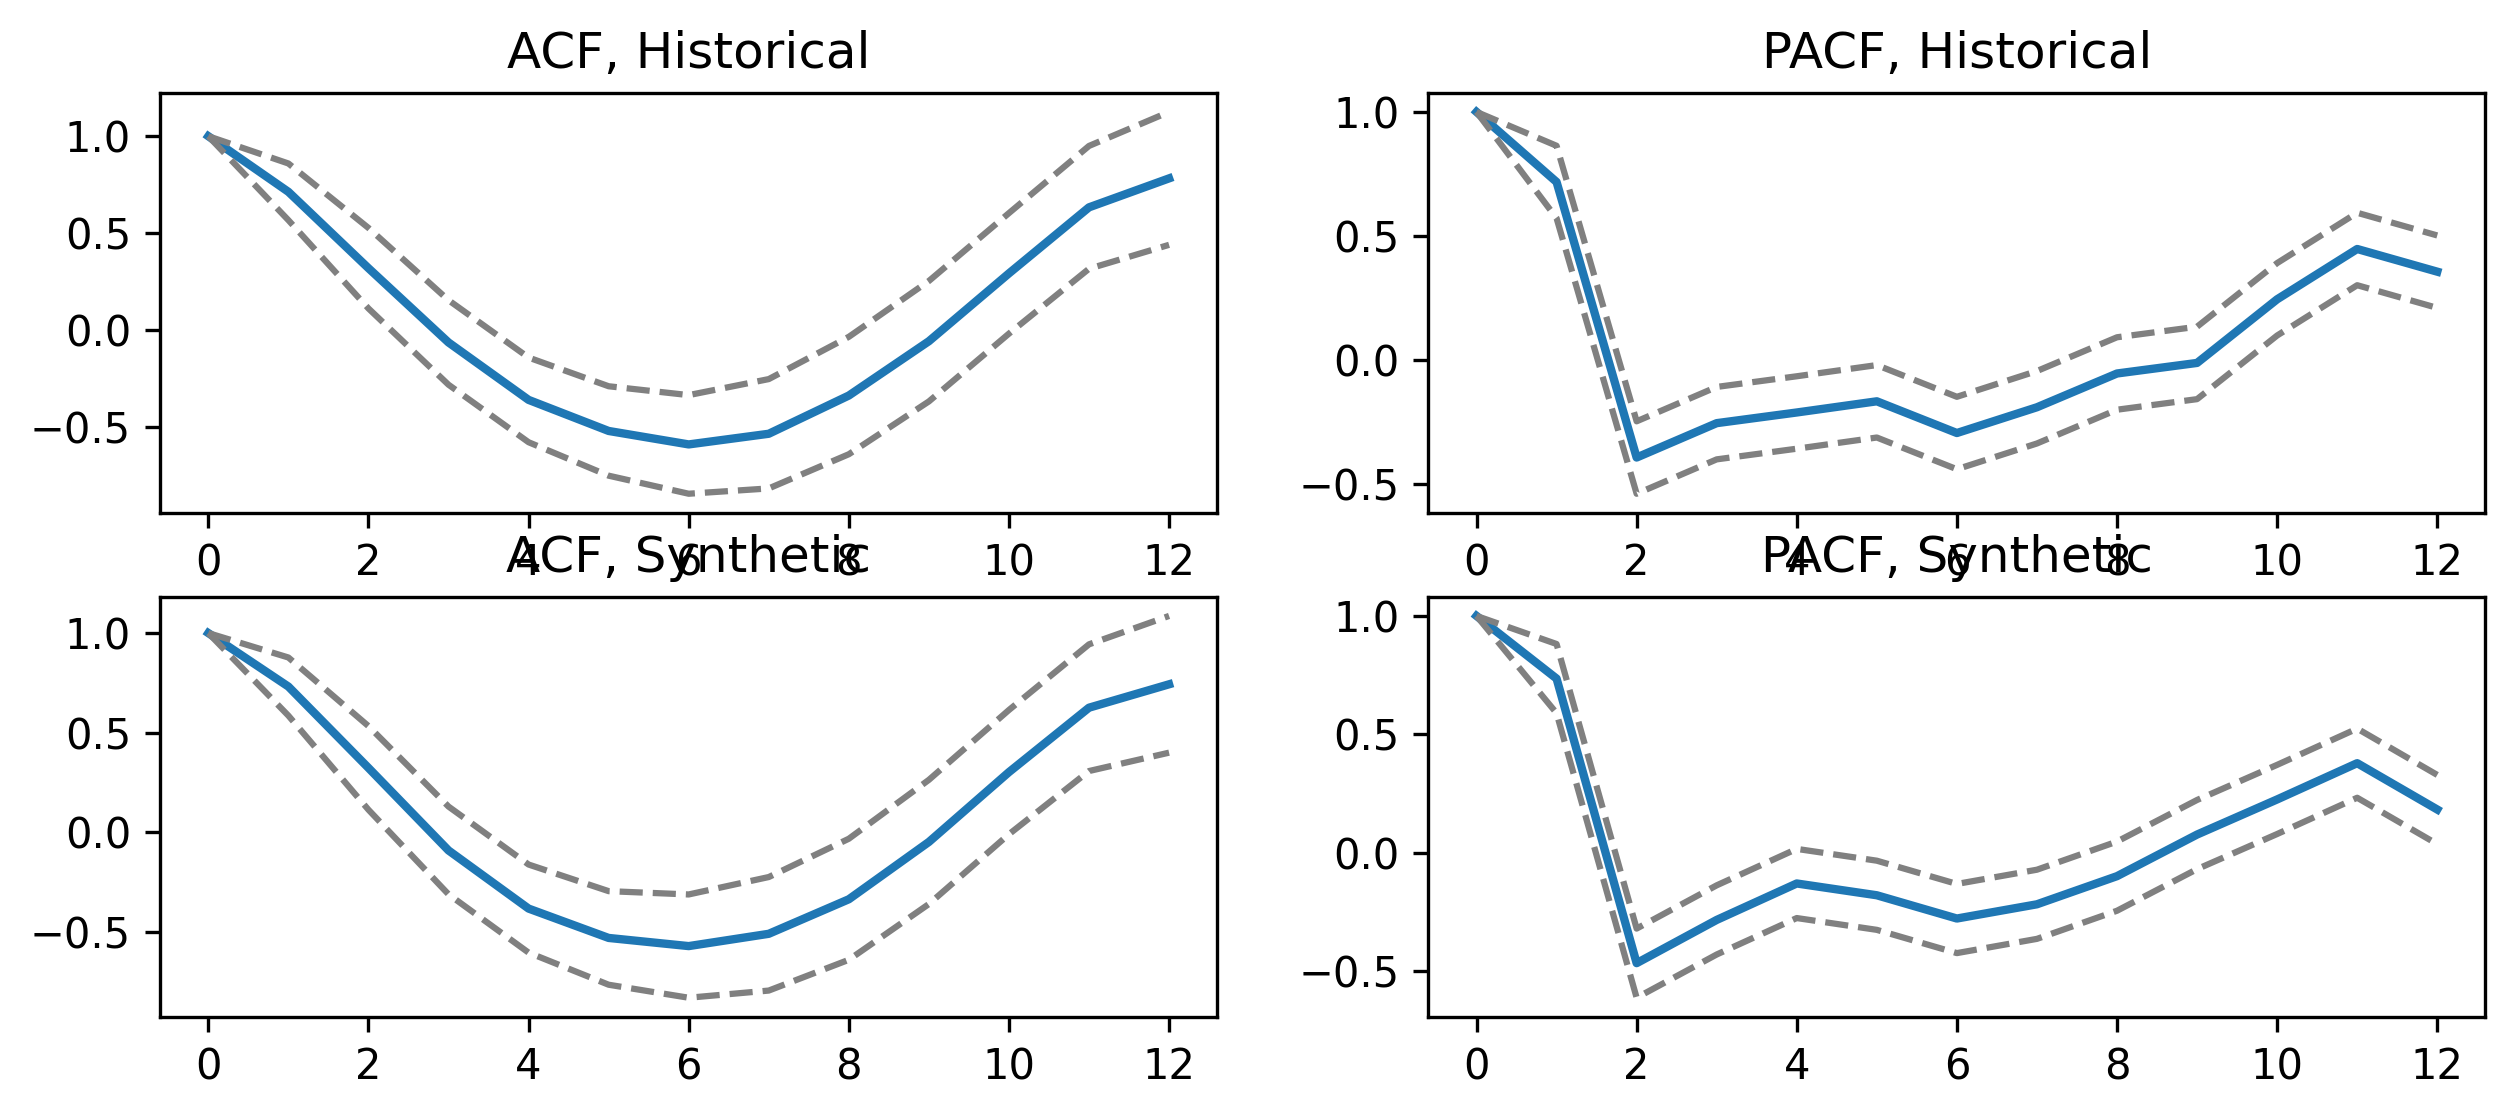

In [20]:
plt.subplot(2,2,1)
acf,ci = stattools.acf(Q, nlags = 12, alpha=0.05)
plt.plot(acf, linewidth=2)
plt.plot(ci, linestyle='dashed', color='0.5')
plt.title('ACF, Historical')

plt.subplot(2,2,2)
pacf,ci = stattools.pacf(Q, nlags = 12, alpha=0.05)
plt.plot(pacf, linewidth=2)
plt.plot(ci, linestyle='dashed', color='0.5')
plt.title('PACF, Historical')

plt.subplot(2,2,3)
acf,ci = stattools.acf(Q_synthetic, nlags = 12, alpha=0.05)
plt.plot(acf, linewidth=2)
plt.plot(ci, linestyle='dashed', color='0.5')
plt.title('ACF, Synthetic')

plt.subplot(2,2,4)
pacf,ci = stattools.pacf(Q_synthetic, nlags = 12, alpha=0.05)
plt.plot(pacf, linewidth=2)
plt.plot(ci, linestyle='dashed', color='0.5')
plt.title('PACF, Synthetic')

plt.show()

---

## Non-stationary generation

In [22]:
# we used this for stationary generation:
mu,sigma,rho = get_monthly_stats(Q)
Q_synthetic = thomasfiering_monthly(mu, sigma, rho, N_years=15)

<ipython-input-14-69e47f17e5d5>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[0] = np.random.normal(mu[0],sigma[0],1)


In non-stationary generation, we will perturb the values of `mu` and `sigma` from historical assumptions.


1. Let's start with the generation of 50 samples of `mu` and `sigma` extracted randomly in a interval:


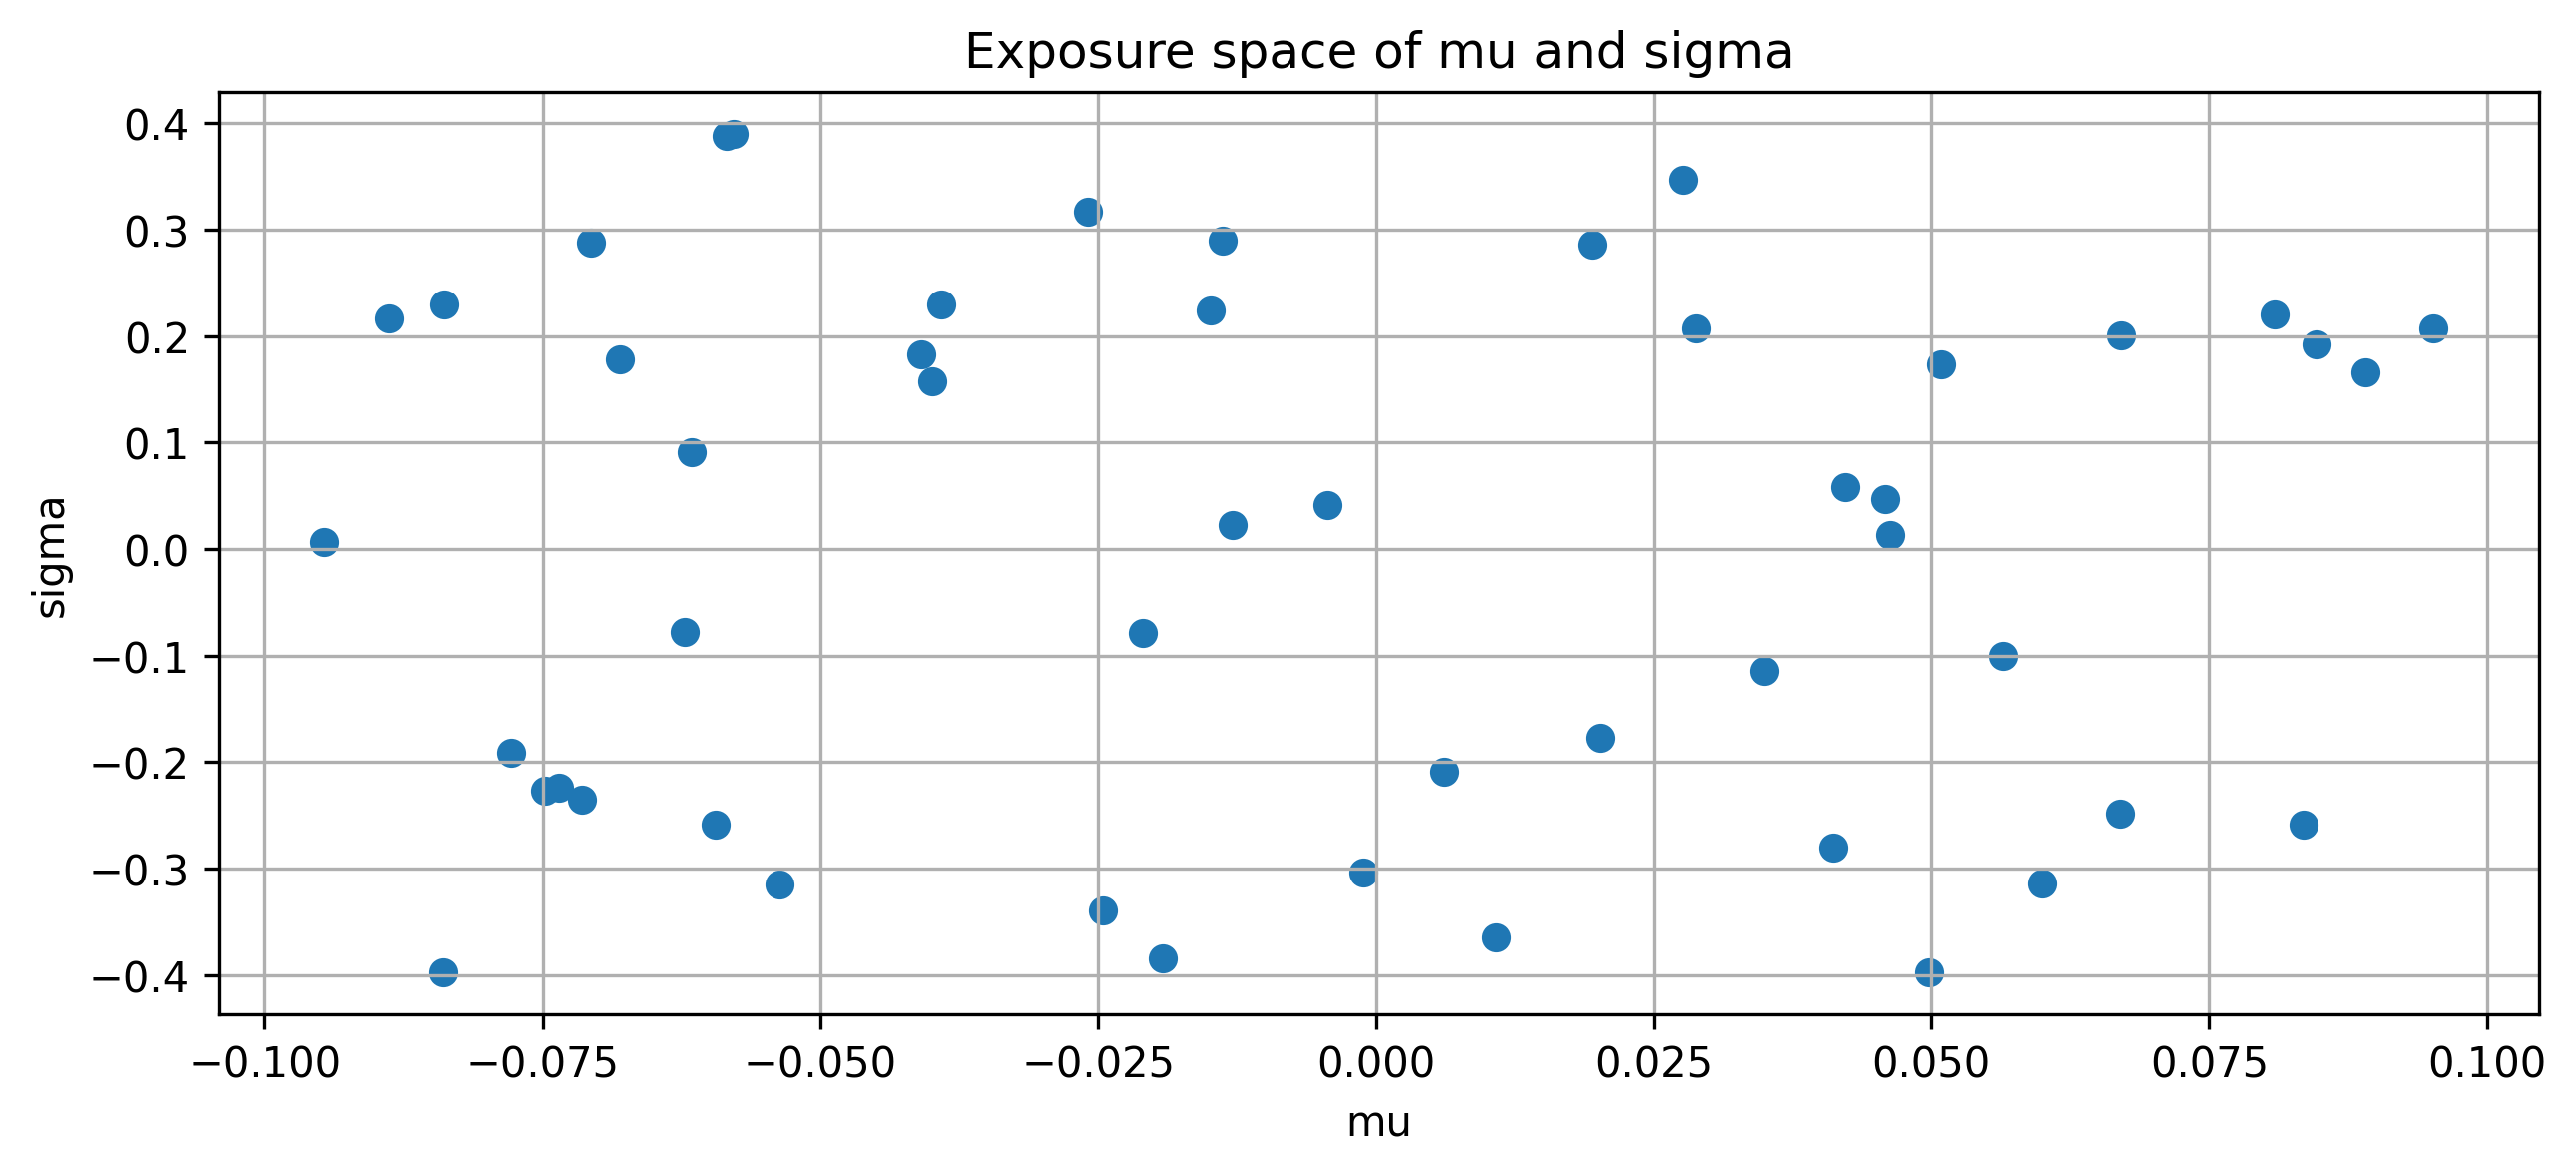

In [23]:
num_samples = 50

# Define bounds for each variable, for example:
range_mu = (-0.1, 0.1)  # -10% to +10%: sample mean in this range
range_sigma = (-0.4, 0.4)  # -40% to +40%: sample variance in this range


# Generate uniform samples within each range
mu_samples = np.random.uniform(range_mu[0], range_mu[1], num_samples)
sigma_samples = np.random.uniform(range_sigma[0], range_sigma[1], num_samples)


# Plot the samples
plt.scatter(mu_samples, sigma_samples)
plt.xlabel('mu')
plt.ylabel('sigma')
plt.title('Exposure space of mu and sigma')
plt.grid(True)
plt.show()

#note: random extraction is an alternative to the regular grid I have on the slides

2. let's use these generated perturbation factors for non-stationary generation

<ipython-input-14-69e47f17e5d5>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[0] = np.random.normal(mu[0],sigma[0],1)


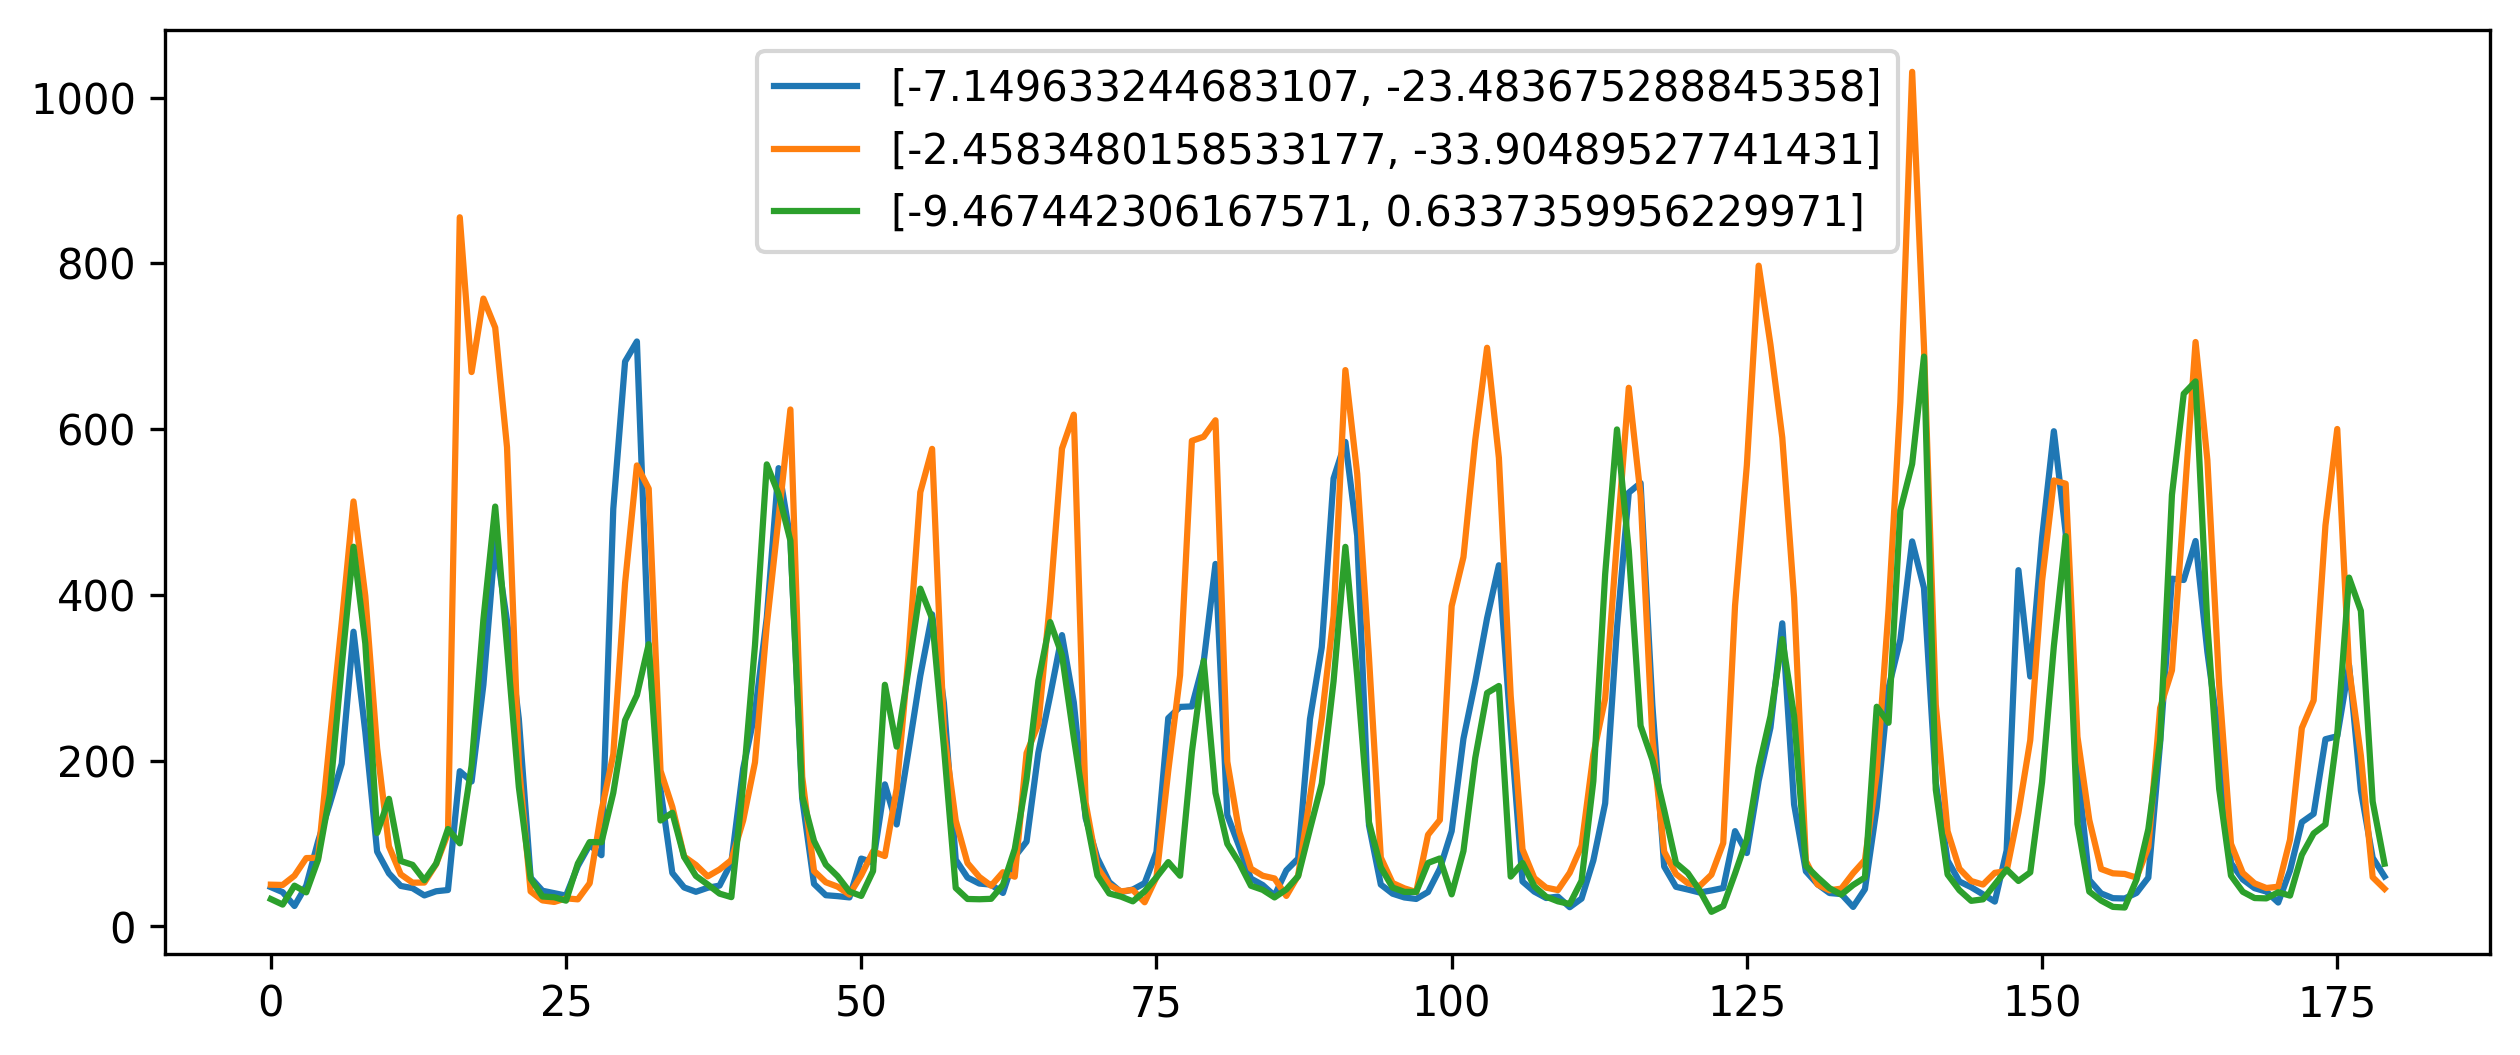

In [24]:
Q_non_stationary = []
for s_mu, s_sigma in zip(mu_samples, sigma_samples):
  perturbed_mu    = mu*(1+s_mu)
  perturbed_sigma = sigma*(1+s_sigma)
  Q_non_stationary.append( thomasfiering_monthly(perturbed_mu, perturbed_sigma, rho, N_years=15) )

# as an example, I'll plot a few scenarios generated:
plt.plot(Q_non_stationary[0], label = str( [mu_samples[0]*100,sigma_samples[0]*100] ))
plt.plot(Q_non_stationary[1], label = str( [mu_samples[1]*100,sigma_samples[1]*100] ))
plt.plot(Q_non_stationary[2], label = str( [mu_samples[2]*100,sigma_samples[2]*100] ))

plt.legend()
plt.show()

### Monthly --> Daily

One way to disaggregate from monthly to daily data is simply linear interpolation between monthly values. It's not very realistic, but I'd rather focus on other aspects right now.

In [29]:
# Define date range for monthly data from 2001-01-01 to 2015-12-31
monthly_index = pd.date_range(start='2001-01-01', end='2015-12-31', freq='MS')
window_size = 7  # Set window size for rolling mean (e.g., 7 for weekly smoothing)

# Process each timeseries: resample to daily and apply rolling mean
Q_nonStationary_daily = []

for scenario in Q_non_stationary:
  Q_nonStationary_daily.append( pd.Series(scenario, index=monthly_index).resample('D').interpolate(method='linear')  )

---

## Simulate the GIbe III reservoir with different inflow trajectories

3. Let's use the code for reservoir simulation we developed previously.

In [25]:
# define/load lake simulation parameters:

sim_step = 60*60*24
S = 1e10   #reservoir max capacity
D = 200* sim_step    # water demand, m3/day.

#operating policy #1
theta = [0.004, -3e7, 0.007]
max_release = 400 * sim_step
Ny = 15

evap = np.loadtxt(url + 'netevap_Gibe1.txt', delimiter=' ') # load cyclostationary evaporation

s0 = S*0.7 # for example, let's inizialize storage value at 70% of the max capacity
stor_to_surface = 0.0142
# stor_to_level = 0.0521*storage^0.3589




In [26]:
#this is the same function developed in L05, except the input is now the inflow rather than theta
def simulate(inflow): #---> only difference wrt L05, previously def simulate(theta):

  # time convention
  inflow_ = np.concatenate(([-999], inflow)) * sim_step

  H = len(inflow)

  # initialize storage vector
  s = np.zeros(len(inflow_))
  l = np.zeros(len(inflow_)) ### new
  r = np.zeros(len(inflow_)) ### new

  s[0] = S*0.7
  l[0] = 0.0521*(s[0]**0.3589)   ### calculate level

  # mass balance
  for t in range(H):
    evaporation_t = evap[t%365]/1000*s[t]*stor_to_surface

    #### new - policy as a piecewise linear function. Substitute s_values with s[t]
    L1 = theta[0]*s[t]
    L2 = D
    L3 = theta[1] + s[t]*theta[2]

    u_t = np.maximum( np.minimum(L1, L2), L3 ) # element-wise max/minimum
    r[t+1] = max( min( u_t, s[t]*(max_release/S)),  0)

    s[t+1] = s[t] + inflow_[t+1] - r[t+1] - evaporation_t # we corrected for sim_step above

    # check minimum storage constraint
    s[t+1] = max(0, s[t+1])
    l[t+1] = 0.0521*(s[t+1]**0.3589)   ### calculate level
    s[t+1] = min(s[t+1], S) #check max storage constraint

  #indicator 1: flood days
  l_threshold = 0.0521*(S**0.3589) #obtain maximum level threshold from max storage
  i1 = np.sum(l > l_threshold) / Ny

  #indicator 2: water demand deficit
  i2 = sum ( (np.maximum(D - r[1:] , 0)/sim_step) **2 ) / H

  return i1, i2


Let's simulate the system under different  inflow scenarios and obtain the performance according to i1 an i2.

In [27]:
i1_historical, i2_historical = simulate(df.inflow) #historical inflow
print(i1_historical, i2_historical) #historical performance values


12.533333333333333 29.806969802603472


In [30]:
i1_nonStationary = []
i2_nonStationary = []
for scenario in Q_nonStationary_daily:
  i1, i2 = simulate(scenario)
  i1_nonStationary.append(i1)
  i2_nonStationary.append(i2)


let's make an assumption on a 'failure' threshold, i.e., if the system performance is worse (higher than threshold) it is considered a failure

Text(0, 0.5, 'sigma')

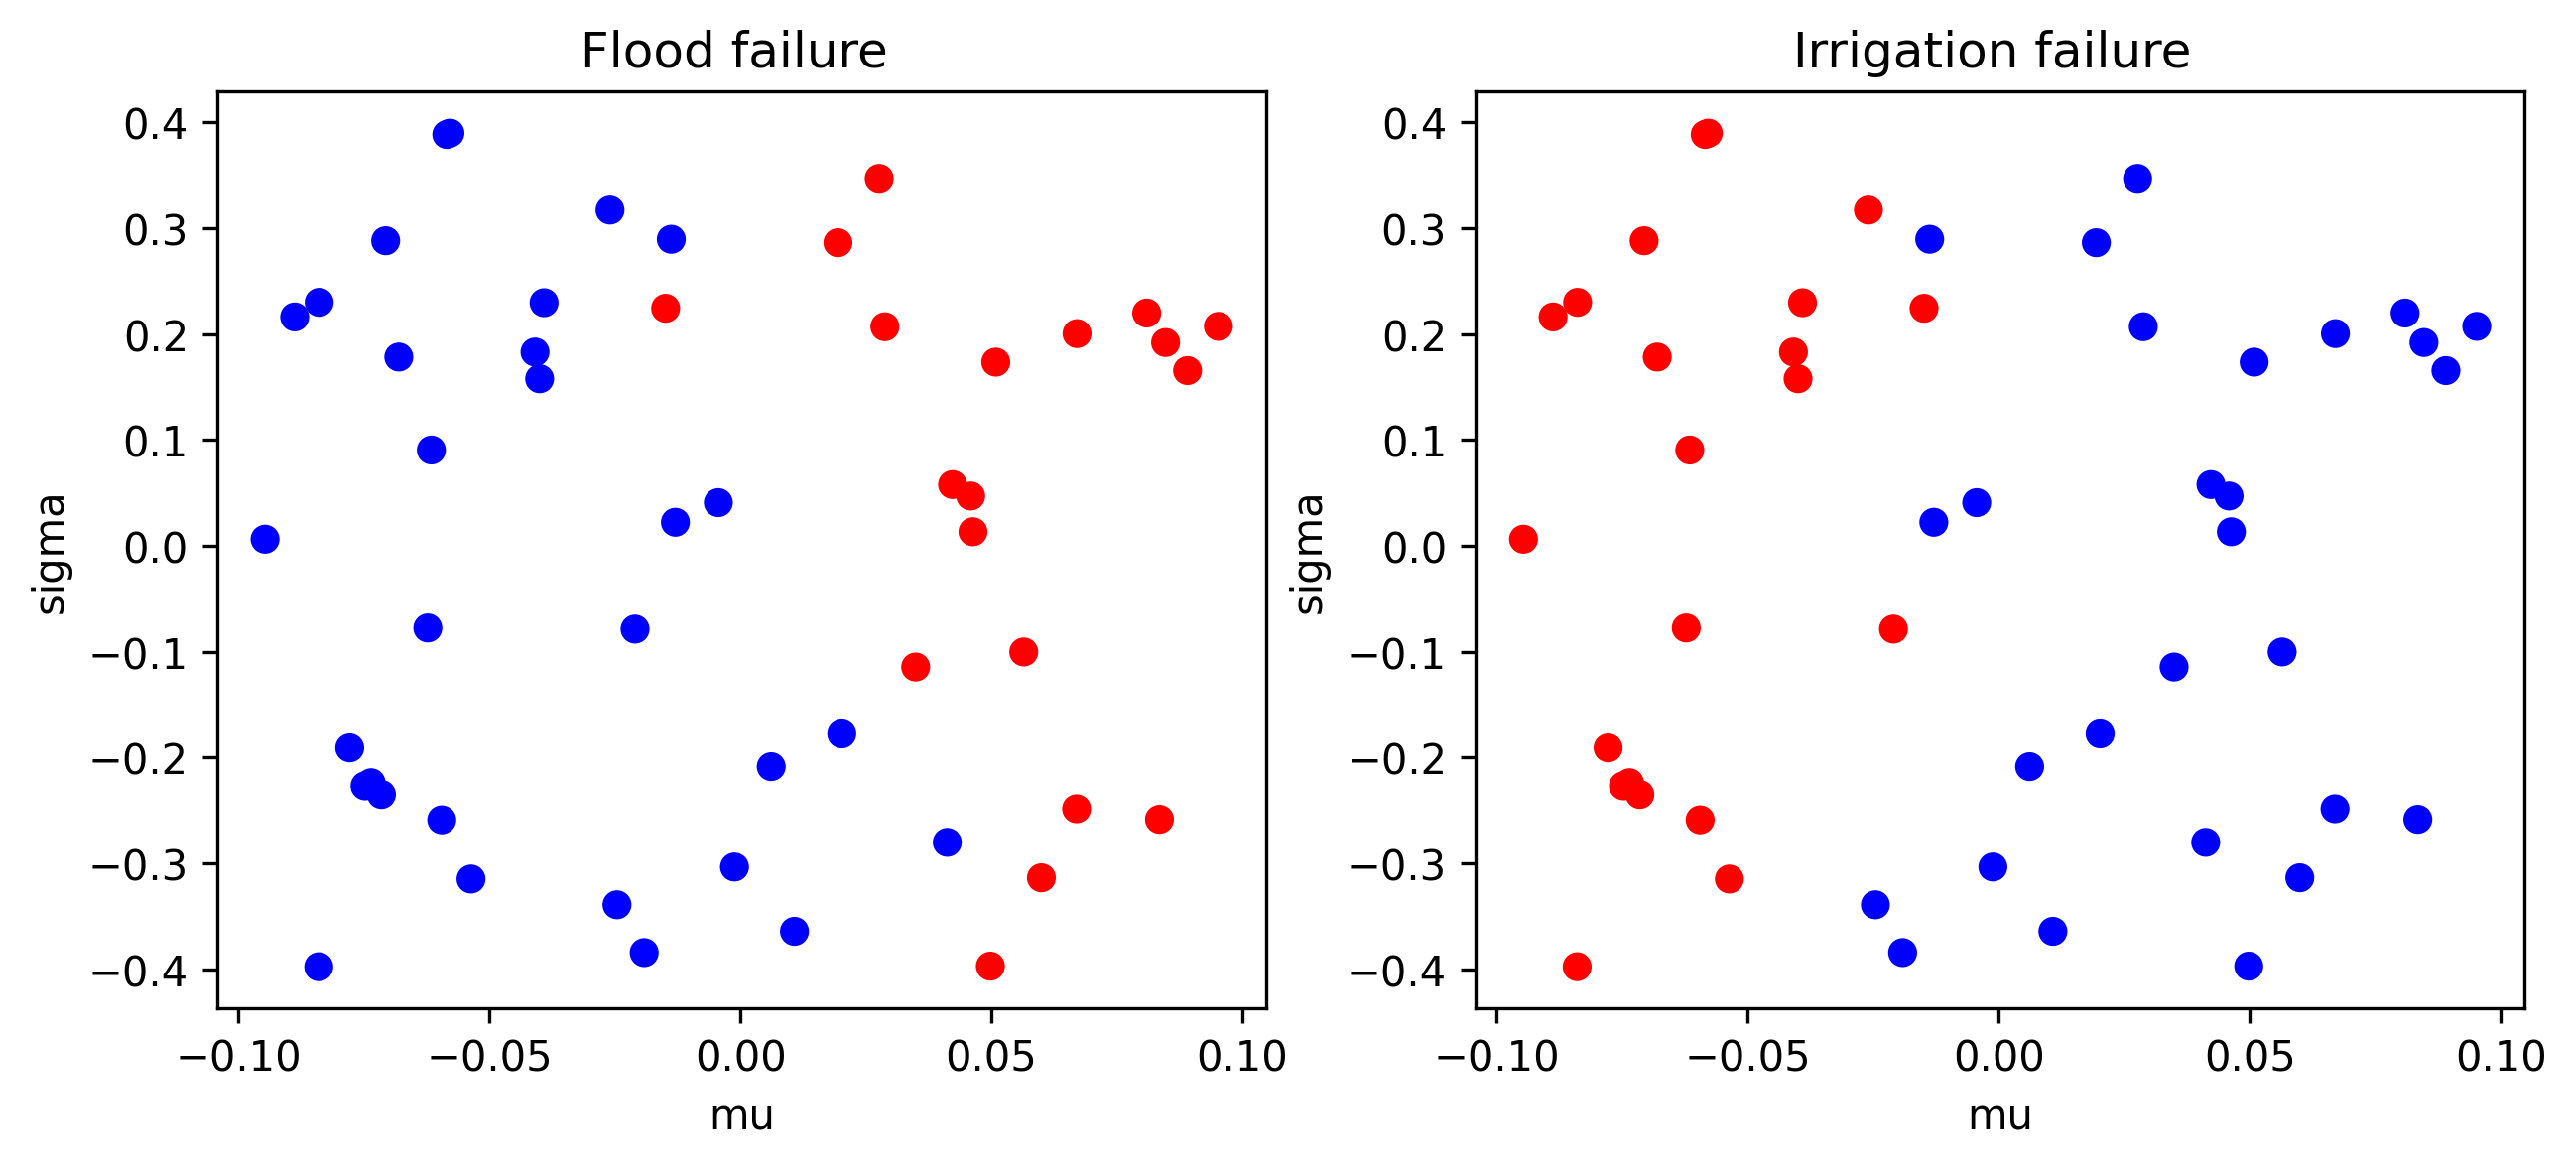

In [32]:
threshold_i1 =  i1_historical*2 #20% higher than historical
threshold_i2 =  i2_historical*3 #40% higher than historical

success_i1 = i1_nonStationary <= threshold_i1
success_i2 = i2_nonStationary <= threshold_i2

plt.subplot(1,2,1)
colors = ['blue' if s == 1 else 'red' for s in success_i1]
plt.scatter(mu_samples, sigma_samples, color=colors)
plt.title('Flood failure ')
plt.xlabel('mu')
plt.ylabel('sigma')

plt.subplot(1,2,2)
colors = ['blue' if s == 1 else 'red' for s in success_i2]
plt.scatter(mu_samples, sigma_samples, color=colors)
plt.title('Irrigation failure ')
plt.xlabel('mu')
plt.ylabel('sigma')